1.1 import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2

from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,accuracy_score
from keras.utils import to_categorical
from keras import applications, optimizers

from keras.models import Sequential, Model, load_model,clone_model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D 
from keras.losses import categorical_crossentropy

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras import applications
#from keras.applications.resnet50 import ResNet50
from keras.layers import BatchNormalization
from keras.layers import Dropout

<a id='step1.2'></a>
1.2.   ****Extracting Train Data****

In [2]:
foldernames = os.listdir("D:/train_data")
categories = []      # list of all categories of animals present
files = []           # list of all images from all categories

for k, folder in enumerate(foldernames):
    filenames = os.listdir("D:/train_data/" + folder);
    for file in filenames:
        files.append("D:/train_data/" + folder + "/" + file)
        categories.append(k)
# creating a dataframe of images and their respective categories        
train_df = pd.DataFrame({
    'filename': files,
    'category': categories
})


train_df = train_df.reset_index(drop=True) # reset index of a Data Frame
train_df

,filename,category
0,D:/train_data/1/0069a0029a632c41efe3d54a19544a...,0
1,D:/train_data/1/010900f4a24072ebafbf0f41a3da4a...,0
2,D:/train_data/1/01355de017e33232538f31b2dac5e4...,0
3,D:/train_data/1/01a52d5938342db6a62ac739b873f1...,0
4,D:/train_data/1/021df905fae3b218774c9ce328db1f...,0
...,...,...
9985,D:/train_data/9/ff8a68a91ae8697addeebe89701165...,9
9986,D:/train_data/9/ff9254bd66b8edb5d86f66ba1b477a...,9
9987,D:/train_data/9/ff9c95e2ebe45920c6630d02473e94...,9
9988,D:/train_data/9/ffa966ff53db7e2f8dc577d7211344...,9


<a id='step1.3'></a>
1.3. Shuffling input and target for optimum training

In [3]:
y = train_df['category']
x = train_df['filename']

x, y = shuffle(x, y, random_state=8)

<a id='step2'></a>
<a id='step2.1'></a>
* 2.1. Function for Resizing and Reshaping the input images

In [4]:
def centering_image(img):
    size = [256,256]
    
#shape:(h×w×t)taking the first2 elements(h,w) and unpacking them appropriately 
    img_size = img.shape[:2]
    
    # extracting the excess space for centering.
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    
#creating centered image by taking a 0-matrix and then re-assigning intensities
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img 

    return resized


<a id='step2.2'></a>
2.2. Image Resizing and converting them to array

In [5]:
images = []

with tqdm(total=len(train_df)) as k:  
    for i, file_path in enumerate(train_df.filename.values):
        
        #color order is changed
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

        #converting images to square
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering the images
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #output 224*224px 
        img = img[16:240, 16:240]
        images.append(img)
        k.update(1)

images = np.array(images)

C:\Users\moheb\AppData\Local\Temp/ipykernel_5156/1365171311.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(train_df)) as k:


  0%|          | 0/9990 [00:00<?, ?it/s]

<a id='step2.3'></a>
2.3. Viewing Images after preprocessing

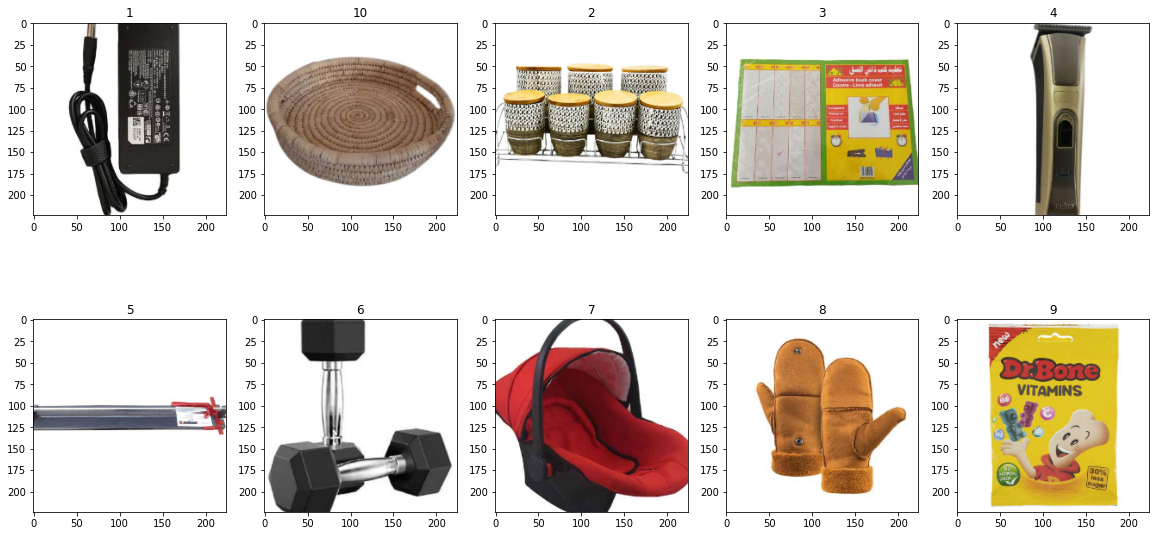

In [8]:
cols=5
fig, ax = plt.subplots(2,5, figsize=(20,10))
for i in range(10):
    path = train_df[train_df.category == i].values[1] #takes path in os of 1 value of figure of each category
#     print(path)
#     image = cv2.imread(path[0])  #     [i//cols, i%cols]
    ax[i//cols, i%cols].set_title(path[0].split('/')[-2]) # -2 is location of name of figure in path
    ax[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

<a id='step2.4'></a>
2.4. Re-Shuffling processed train data and converting to array 

In [9]:
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)

<a id='step2.5'></a>
2.5. Train val split,OneHotVectorizing categories, Input normalization

In [10]:
#train_test split
val_size = int(round(0.8*len(y)))
x_train = x[:val_size]
y_train = y[:val_size]
x_val = x[val_size:]
y_val = y[val_size:]

print('x_train Shape:', x_train.shape, '\t x_test Shape:',x_val.shape)
print('y_train Shape: ', y_train.shape, '\t y_test Shape:',y_val.shape)


y_train = to_categorical(y_train) 
y_val = to_categorical(y_val)

#dividing each intensity in array by 225 ( 225 is max intensity in RGB)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255 
x_val /= 255

print('x_train Shape:', x_train.shape, '\t x_test Shape:',x_val.shape)
print('y_train Shape: ', y_train.shape, '\t y_test Shape:',y_val.shape)
print('image Shape:', x_train[0].shape)

x_train Shape: (7992, 224, 224, 3) 	 x_test Shape: (1998, 224, 224, 3)
y_train Shape:  (7992,) 	 y_test Shape: (1998,)
x_train Shape: (7992, 224, 224, 3) 	 x_test Shape: (1998, 224, 224, 3)
y_train Shape:  (7992, 10) 	 y_test Shape: (1998, 10)
image Shape: (224, 224, 3)


<a id='step2.7'></a>
2.7. Data Augmentation

In [12]:
# ImageDataGenerator for data augmentation 

train_data_gen = ImageDataGenerator(rotation_range=45, 
                                    width_shift_range=0.1,
                                    height_shift_range=0.1, 
                                    horizontal_flip=True)
train_data_gen.fit(x_train) 

<a id='step2.8'></a>
2.8. Preprocessing test data

In [13]:
test_images = []
test_df = pd.DataFrame(columns=['filename'])
actual_pred=pd.DataFrame(columns=['Category'])
for i in range(10):
    test_df = test_df.append(df[df.category == i].iloc[500:502,:1])
    actual_pred=actual_pred.append(df[df.category == i].iloc[500:502,1:])

    test_df = test_df.reset_index(drop=True)
    actual_pred = actual_pred.reset_index(drop=True)
with tqdm(total=len(test_df)) as k:  
    for i, file_path in enumerate(test_df.filename.values):
        
        #color order is changed
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

        #converting images to square
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering the images
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #output 224*224px 
        img = img[16:240, 16:240]
        test_images.append(img)
        k.update(1)
test_images = np.array(test_images).reshape(-1,224,224,3)



AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
# print(test_df.shape())

<a id='step3.1'></a>

3.1. Creating a Convolutional Neural Network using VGG16 

In [14]:
rows,cols,channel = 224, 224, 3

epochs = 25
learning_rate = 0.001
decay_rate = learning_rate / epochs
momentum =0.9
sgd= optimizers.SGD(lr=learning_rate, momentum=momentum,
                      decay=decay_rate, nesterov=False)

base_model1 = applications.VGG16(weights='imagenet', include_top=False,
                                    input_shape=(224,224,3))
model1 = Sequential()
model1.add(Flatten(input_shape= base_model1.output_shape[1:]))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(10, activation='softmax'))

vgg16_model = Model(inputs=base_model1.input,
                        outputs=model1(base_model1.output))

vgg16_model.compile(loss='binary_crossentropy',
                        optimizer=sgd,metrics=['accuracy'])
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
vgg16_model.summary()



C:\Users\moheb\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<a id='step3.2'></a>

3.2. Creating a Convolutional Neural Network using ResNet50


In [15]:
epochs = 25
learning_rate = 0.001
decay_rate = learning_rate / epochs
momentum =0.8
sgd= optimizers.SGD(lr=learning_rate, momentum=momentum,
                      decay=decay_rate, nesterov=False)

base_model2 =ResNet50(weights=None, include_top=False, input_shape=(224,224,3))
model2 = Sequential()
model2.add(Flatten(input_shape= base_model2.output_shape[1:]))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(10, activation='softmax'))

ResNet50_model = Model(inputs=base_model2.input,
                        outputs=model2(base_model2.output))
ResNet50_model.compile(loss='binary_crossentropy',
                        optimizer= sgd,
                          metrics=['accuracy'])
ResNet50_model.summary()

NameError: name 'ResNet50' is not defined

<a id='step3.3'></a>
3.3. LEARNING RATE FINDER function

In [16]:
class lr_finder():
    
    def __init__(self,model,begin_lr=1e-8, end_lr=1e-1, num_epochs=10, period=5):
        self.period = period
        # make a copy of the model to train through a sweep of learning rates
        self.model = clone_model(model)
        self.begin_lr = np.log(begin_lr)/np.log(10)
        self.end_lr = np.log(end_lr)/np.log(10)
        self.num_epochs = num_epochs
        self.lower_bound = begin_lr
        self.upper_bound = 1e-2 #end_lr
        # define learning rates to use in schedules
        self.lr = np.logspace(self.begin_lr,self.end_lr,self.num_epochs)
        self.clr = np.logspace(np.log(self.lower_bound)/np.log(10), np.log(self.upper_bound)/np.log(10), self.period)
        
        
    def reset_model(self, model):
        # reset the model to find new lr bounds 
        self.begin_lr = -10 
        self.end_lr = 0 
        self.lr = np.logspace(self.begin_lr,self.end_lr,self.num_epochs)
        self.model = clone_model(model)
        
    def lr_schedule(self,epoch):
        # return lr according to a sweeping schedule
        if epoch < self.num_epochs:
            return self.lr[epoch]
        else:
            return self.lr[0]
        
    def clr_schedule(self,epoch,period=5):
        # return lr according to cyclical learning rate schedule
        my_epoch = int(epoch % self.period)
        return self.clr[my_epoch]
    
    def lr_vector(self,epochs):
        # return the vector of learning rates used in a schedule
        lrv = []
        for ck in range(epochs):
            lrv.append(self.lr_schedule(ck))
        return lrv
    
    def lr_plot(self,history_loss,please_plot=True):
        # plot the lr sweep results and set upper and lower bounds on learning rate
        x_axis = self.lr_vector(self.num_epochs)
        y_axis = history_loss
                   
        d_loss = []
        for cc in range(1,len(y_axis)):
            if cc == 1:
                d_loss.append(y_axis[cc] - y_axis[cc-1])
            else:
                d_loss.append(0.8*(y_axis[cc] - y_axis[cc-1])+0.2*(y_axis[cc-1] - y_axis[cc-2]))
        d_loss = np.array(d_loss)
        
        self.lower_bound = x_axis[d_loss.argmin()]
        self.upper_bound = x_axis[np.array(y_axis).argmin()]
        self.clr = np.logspace(np.log(self.lower_bound)/np.log(10), np.log(self.upper_bound)/np.log(10), self.period)
        
        print("recommended learning rate: more than %.2e, less than %.2e "%(self.lower_bound, self.upper_bound))
        if(please_plot):
            plt.figure(figsize=(10,5))
            plt.loglog(x_axis,y_axis)
            plt.xlabel('learning rate')
            plt.ylabel('loss')
            plt.title('Loss / learning rate progression')
            plt.show()
            
    def get_lr(self,epoch):
        # return the geometric mean of the upper and lower bound learning rates
        return (self.lower_bound *self.upper_bound)**(1/2)


<a id='step3.4'></a>
3.4. Obtaining optimum Learning Rate for each model

In [ ]:
# lrf = lr_finder(vgg16_model,begin_lr=1e-8, end_lr=1e0, num_epochs=20)
# lr_rate = LearningRateScheduler(lrf.lr_schedule)
# steps_per_epoch = int(len(y_train)/32)
# max_epochs = 20

# lrf.model.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(),
#                   metrics=['accuracy'])


# lr_history = lrf.model.fit_generator(train_data_gen.flow(x_train, y_train,
#                                             batch_size=32),
#                                 steps_per_epoch=steps_per_epoch/20,
#                                 validation_data=(x_val, y_val),
#                                 validation_steps=50,
#                                 epochs=max_epochs,
#                                 callbacks=[lr_rate],
#                                 verbose=0)
# lrf.lr_plot(lr_history.history['loss'])

<a id='step3.5'></a>
3.5. Training Models
> ResNet50

In [ ]:
batch_size =32 #32 ,50#hyper parameters obtained by tuning
epochs = 30  #
neural_ntwk2= ResNet50_model.fit_generator(train_data_gen.flow(x_train, y_train,
                                            batch_size=batch_size),
                    steps_per_epoch= x_train.shape[0] // batch_size,
                    validation_data=(x_val, y_val),epochs=epochs,
                    callbacks=[ModelCheckpoint ('ResNet50transferlearning.model',
                               monitor='val_acc')])

> VGG16

In [20]:
batch_size =50 
epochs = 5  
neural_ntwk1 = vgg16_model.fit_generator(train_data_gen.flow(x_train, y_train,
                                        batch_size=batch_size),
                    steps_per_epoch= x_train.shape[0] // batch_size,
                    epochs=epochs,validation_data=(x_val, y_val),
                    callbacks=[ModelCheckpoint('VGG16-transferlearning.model',
                               monitor='val_acc')])


                                    

C:\Users\moheb\AppData\Local\Temp/ipykernel_5156/1622956009.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  neural_ntwk1 = vgg16_model.fit_generator(train_data_gen.flow(x_train, y_train,


Epoch 1/5
159/159 [==============================] - ETA: 0s - loss: 0.3200 - accuracy: 0.1748  

INFO:tensorflow:Assets written to: VGG16-transferlearning.model\assets


INFO:tensorflow:Assets written to: VGG16-transferlearning.model\assets


159/159 [==============================] - 12609s 79s/step - loss: 0.3200 - accuracy: 0.1748 - val_loss: 0.2989 - val_accuracy: 0.2928
Epoch 2/5
159/159 [==============================] - ETA: 0s - loss: 0.2895 - accuracy: 0.3033  

INFO:tensorflow:Assets written to: VGG16-transferlearning.model\assets


INFO:tensorflow:Assets written to: VGG16-transferlearning.model\assets


159/159 [==============================] - 12597s 79s/step - loss: 0.2895 - accuracy: 0.3033 - val_loss: 0.2691 - val_accuracy: 0.3714
Epoch 3/5
159/159 [==============================] - ETA: 0s - loss: 0.2705 - accuracy: 0.3679  

INFO:tensorflow:Assets written to: VGG16-transferlearning.model\assets


INFO:tensorflow:Assets written to: VGG16-transferlearning.model\assets


159/159 [==============================] - 12488s 79s/step - loss: 0.2705 - accuracy: 0.3679 - val_loss: 0.2558 - val_accuracy: 0.4144
Epoch 4/5
156/159 [============================>.] - ETA: 4:00 - loss: 0.2579 - accuracy: 0.4131

KeyboardInterrupt: 

<a id='step3.6'></a>
3.6. Plotting loss and accuracy curves

In [ ]:
# print("VGG16: Epochs={0:d}, Train accuracy={1:.5f}, Val accuracy={2:.5f}".format(epochs,neural_ntwk1.history['accuracy'][epochs-1],
#               neural_ntwk1.history['val_accuracy'][epochs-1]))
print("ResNet50: Epochs={0:d}, Train accuracy={1:.5f},Val accuracy={2:.5f}"
      .format(epochs,neural_ntwk2.history['accuracy'][epochs-1],
              neural_ntwk2.history['val_accuracy'][epochs-1]))

def show_plots(neural_ntwk):
    loss_vals = neural_ntwk['loss']
    val_loss_vals = neural_ntwk['val_loss']
    epochs = range(1, len(neural_ntwk['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    ax[0].plot(epochs, loss_vals, color='R',marker='o',
               linestyle=' ', label='Train Loss')
    ax[0].plot(epochs, val_loss_vals, color='B',
               marker='*', label='Val Loss')
    ax[0].set(title='Train & Val Loss', xlabel='Epochs',ylabel='Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = neural_ntwk['accuracy']
    val_acc_vals = neural_ntwk['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o',
               ls=' ', label='Train Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick',
               marker='*', label='Val Accuracy')
    ax[1].set(title='Train & Val Accuracy',xlabel='Epochs',ylabel='Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals
# show_plots(neural_ntwk1.history)
show_plots(neural_ntwk2.history)
show_plots(neural_ntwk1.history)

Obtained Accuracy:
> VGG16: Epochs=25, Train accuracy=0.97040, Val accuracy=0.96210
> ResNet50: Epochs=25, Train accuracy=0.90222,Val accuracy=0.90170

<a id='step4'></a>
4. Predicting Categories for Test Data

In [ ]:
test_prediction1 = vgg16_model.predict(test_images)
test_prediction2 = ResNet50_model.predict(test_images)

<a id='step4.1'></a>
4.1. Viewing Predictions

In [ ]:
actual_pred['category']=actual_pred['category'].astype('int')
for i in range(20):
    predict1= test_prediction1[i].argmax()
    predict2= test_prediction2[i].argmax()
    actual=actual_pred['category'][i]
    plt.imshow(test_images[i])
    plt.title("Actual: {1},  VGG: {0},  ResNet:{2}".format((animal_names[actual]),(animal_names[predict1]),(animal_names[predict2])), fontsize=10)
    plt.show()
